In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import fsolve
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar as sc
from iapws import IAPWS97 as steam
import os

In [14]:
path = os.path.dirname(os.path.dirname(os.getcwd()))

data_path = '\\Electrolyte_Calibration\\'

full_path = path + data_path

full_path

'c:\\Users\\ethan\\OneDrive\\Desktop\\MODES\\Battery Data\\Electrolyte_Calibration\\'

## Pull the data, put into pandas dataframes

In [43]:
# ----- Import data using the correct path
df0 = pd.read_csv(full_path + '0M_3_26_24v2.tsv', sep = '\t')       # 0 M calibration
df1 = pd.read_csv(full_path + '-4M_3_25_24.tsv', sep = '\t')        # .4 M calibration
df2 = pd.read_csv(full_path + '-7M_3_25_24.tsv', sep = '\t')        # .7 M calibration
df3 = pd.read_csv(full_path + '1M_3_25_24.tsv', sep = '\t')         # 1 M calibration
df4 = pd.read_csv(full_path + '1-3M_3_25_24.tsv', sep = '\t')       # 1.3 M calibration
df5 = pd.read_csv(full_path + '1-6M_3_25_24.tsv', sep = '\t')       # 1.6 M calibration

bkg = pd.read_csv(full_path + 'Background Background_3_25_24.tsv', sep = '\t') # background calibration

# display, just for kicks and giggles
display(df0)

,X,Y
0,350.022479,0.019909
1,350.504604,0.020276
2,350.986728,0.019524
3,351.468853,0.017839
4,351.950977,0.015640
...,...,...
7567,3998.259529,1.021553
7568,3998.741653,1.020485
7569,3999.223778,1.019325
7570,3999.705903,1.018123


## Calculate the absorbances with the background

In [44]:
A0 = df0
A0['Y'] = -np.log10(A0['Y'] / bkg['Y'])
A1 = df1
A1['Y'] = -np.log10(A1['Y'] / bkg['Y'])
A2 = df2
A2['Y'] = -np.log10(A2['Y'] / bkg['Y'])
A3 = df3
A3['Y'] = -np.log10(A3['Y'] / bkg['Y'])
A4 = df4
A4['Y'] = -np.log10(A4['Y'] / bkg['Y'])
A5 = df5
A5['Y'] = -np.log10(A5['Y'] / bkg['Y'])

display(A0)

,X,Y
0,350.022479,-0.442656
1,350.504604,-0.405504
2,350.986728,-0.371412
3,351.468853,-0.325104
4,351.950977,-0.252678
...,...,...
7567,3998.259529,0.053454
7568,3998.741653,0.053546
7569,3999.223778,0.053672
7570,3999.705903,0.053820


## Plot each spectrum

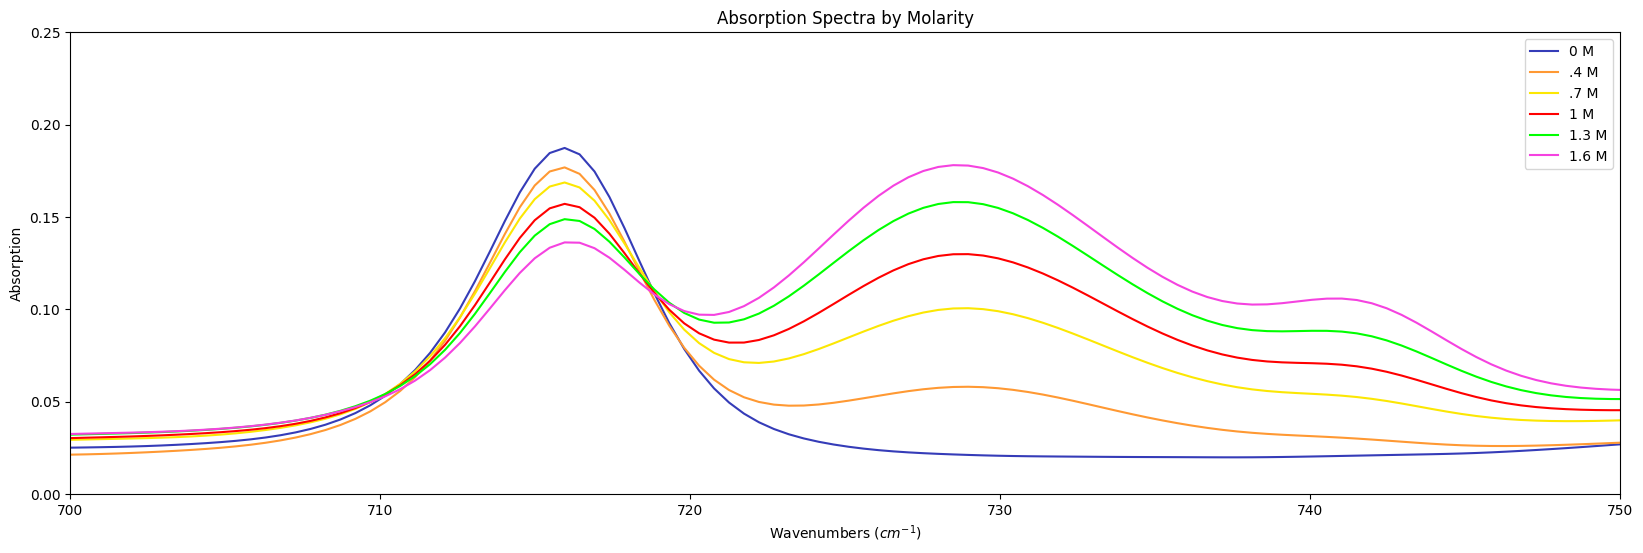

In [69]:
# ----- Plot the spectra on the same graph
x = 'X'
y = 'Y'

plt.figure(figsize = (20,6))

plt.plot(A0[x],A0[y],label = '0 M', color = '#353cb8')
plt.plot(A1[x],A1[y],label = '.4 M', color = '#ff9933')
plt.plot(A2[x],A2[y],label = '.7 M', color = '#fce703')
plt.plot(A3[x],A3[y],label = '1 M', color = '#ff0000')
plt.plot(A4[x],A4[y],label = '1.3 M', color = '#00ff00')
plt.plot(A5[x],A5[y],label = '1.6 M', color = '#f542e0')

# input to determine view range
low_lim = int(input('Lower Limit: (350)'))
up_lim = int(input('Upper Limit: (4000)'))

# formatting
plt.legend()
plt.title('Absorption Spectra by Molarity')
plt.xlabel(r'Wavenumbers ($cm^{-1}$)')
plt.ylabel('Absorption')
plt.ylim(0,.25)
plt.xlim(low_lim,up_lim)
plt.show()

## Create the polynomial fits

In [91]:
# ----- Find the desired range of data
# the lower and upper bounds, approximately where the graphs all intersect
low_716 = 710
high_716 = 719

# Calculate differences
absolute_diff_low = (A0[x] - low_716).abs()
absolute_diff_high= (A0[x] - high_716).abs()

# Find the index of the row with the smallest difference
low0 = absolute_diff_low.idxmin()
high0 = absolute_diff_high.idxmin()

# ----- Obtain the best fit for the data
def zero_M(o,a,b,c,d,e):
    y = (a * o**4) + (b * o**3) + (c * o**2) + (d * o) + e
    return y

# fit the zero molar curve, if possible
# params0,extras = curve_fit(zero_M,A0[x][low0:high0],A0[y][low0:high0])
params0 = np.polyfit(A0[x][low0:high0],A0[y][low0:high0],8)

# output
print(params0)

[ 2.11216163e-14 -4.14729420e-11  1.07590033e-08  1.73091752e-05
  6.99681897e-06 -8.82673791e+00 -2.80543061e+03  5.50316110e+06
 -1.42874372e+09]


C:\Users\ethan\AppData\Local\Temp\ipykernel_272\2923631278.py:21: RankWarning: Polyfit may be poorly conditioned
  params0 = np.polyfit(A0[x][low0:high0],A0[y][low0:high0],8)


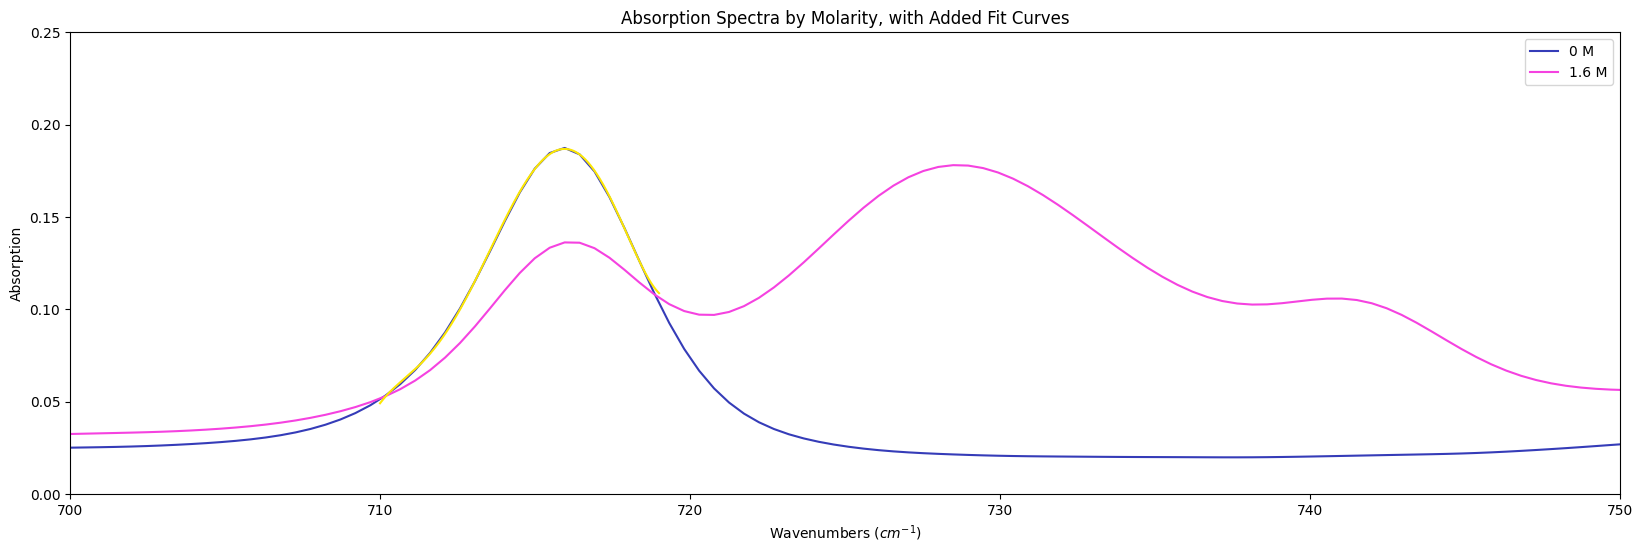

In [92]:
plt.figure(figsize = (20,6))

plt.plot(A0[x],A0[y],label = '0 M', color = '#353cb8')
# plt.plot(A1[x],A1[y],label = '.4 M', color = '#ff9933')
# plt.plot(A2[x],A2[y],label = '.7 M', color = '#fce703')
# plt.plot(A3[x],A3[y],label = '1 M', color = '#ff0000')
# plt.plot(A4[x],A4[y],label = '1.3 M', color = '#00ff00')
plt.plot(A5[x],A5[y],label = '1.6 M', color = '#f542e0')

x1 = np.linspace(low_716,high_716,1000)
plt.plot(x1,np.polyval(params0,x1),color = '#fce703')

# input to determine view range
low_lim = int(input('Lower Limit: (350)'))
up_lim = int(input('Upper Limit: (4000)'))

# formatting
plt.legend()
plt.title('Absorption Spectra by Molarity, with Added Fit Curves')
plt.xlabel(r'Wavenumbers ($cm^{-1}$)')
plt.ylabel('Absorption')
plt.ylim(0,.25)
plt.xlim(low_lim,up_lim)
plt.show()